# Introduction to MOABB

**References :** 
- https://github.com/plcrodrigues/Workshop-MOABB-BCI-Graz-2019/tree/master/notebooks
- https://github.com/NeuroTechX/moabb/tree/master/tutorials

In [1]:
%matplotlib notebook 

# Imports
from moabb.evaluations import WithinSessionEvaluation
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
from sklearn.pipeline import make_pipeline

def plot_results(results, hue=None):
    return sns.catplot(kind='bar', x="score", y="subject", hue=hue, col="dataset", data=results, palette="magma")

## MOABB Exploration

In [2]:
from moabb import paradigms
dir(paradigms)

['BaseMotorImagery',
 'BaseP300',
 'BaseParadigm',
 'BaseSSVEP',
 'FakeDataset',
 'FakeImageryParadigm',
 'FakeP300Paradigm',
 'FakeSSVEPParadigm',
 'FilterBank',
 'FilterBankLeftRightImagery',
 'FilterBankMotorImagery',
 'FilterBankSSVEP',
 'LeftRightImagery',
 'MotorImagery',
 'P300',
 'SSVEP',
 'SinglePass',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'abc',
 'base',
 'log',
 'logging',
 'mne',
 'motor_imagery',
 'np',
 'p300',
 'pd',
 'ssvep',
 'utils']

In [3]:
paradigm = paradigms.LeftRightImagery()

help(paradigm)

Help on LeftRightImagery in module moabb.paradigms.motor_imagery object:

class LeftRightImagery(SinglePass)
 |  LeftRightImagery(**kwargs)
 |  
 |  Motor Imagery for left hand/right hand classification
 |  
 |  Metric is 'roc_auc'
 |  
 |  Method resolution order:
 |      LeftRightImagery
 |      SinglePass
 |      BaseMotorImagery
 |      moabb.paradigms.base.BaseParadigm
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  used_events(self, dataset)
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  scoring
 |      Property that defines scoring metric (e.g. ROC-AUC or accuracy
 |      or f-score), given as a sklearn-compatible string or a compatible
 |      sklearn scorer.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:

In [4]:
datasets = paradigm.datasets
dataset = datasets[0]
dataset.__dict__.keys()

dict_keys(['subject_list', 'n_sessions', 'event_id', 'code', 'interval', 'paradigm', 'doi', 'unit_factor'])

In [5]:
dataset.event_id

{'left_hand': 1, 'right_hand': 2, 'feet': 3, 'tongue': 4}

In [6]:
sessions = dataset._get_single_subject_data(subject=1)
sessions

{'session_T': {'run_0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_2': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_3': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_4': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_5': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>},
 'session_E': {'run_0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_2': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_3': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_4': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_5': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>}}

In [7]:
raw = sessions["session_T"]["run_0"]
raw

<RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>

<IPython.core.display.Javascript object>


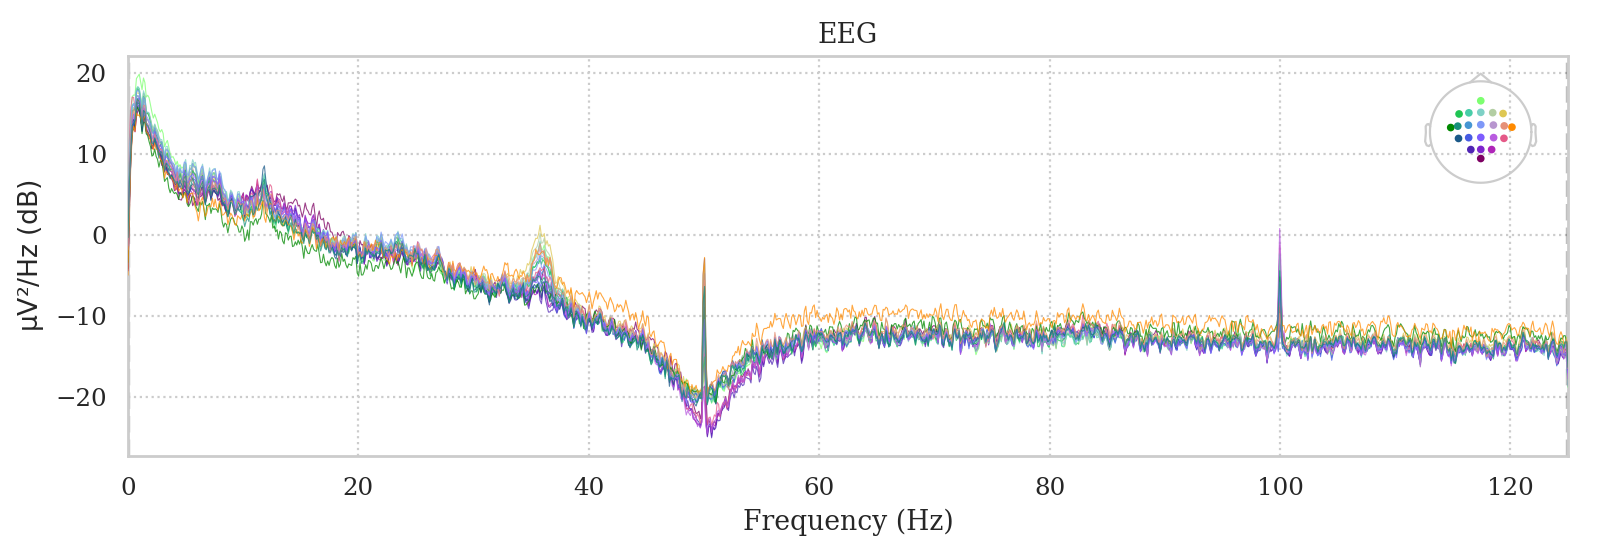

Effective window size : 8.192 (s)


<IPython.core.display.Javascript object>


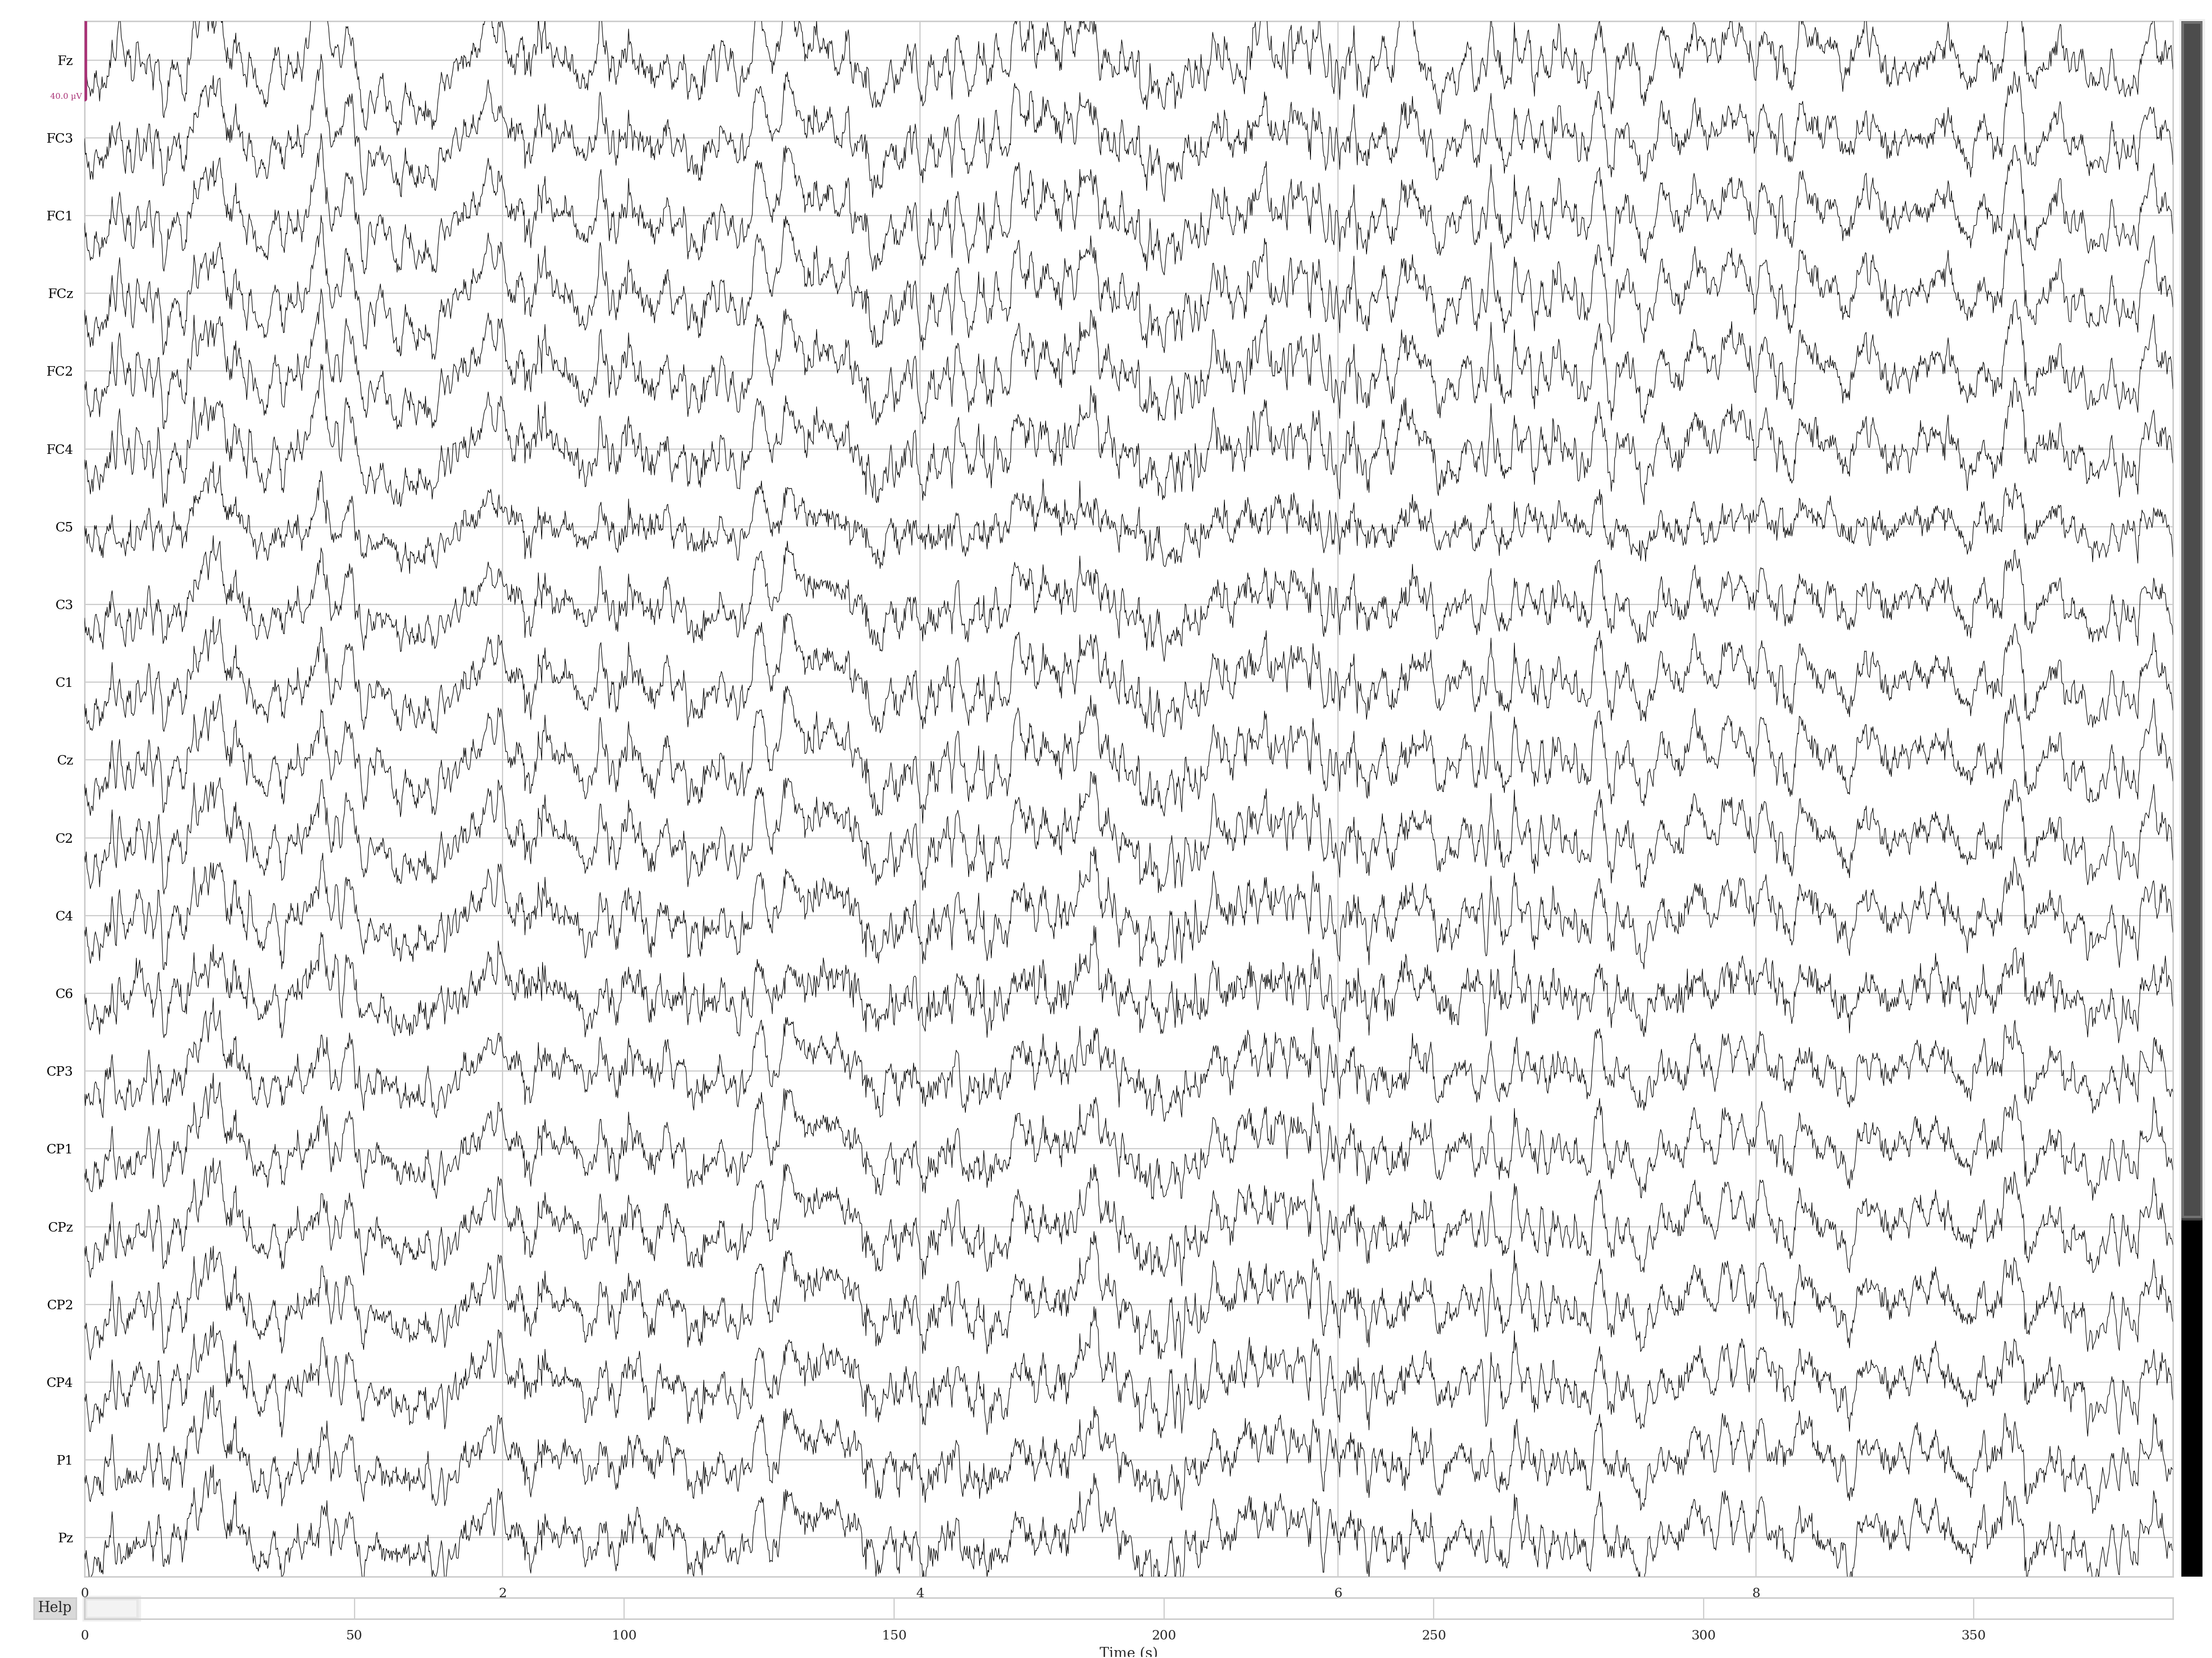

In [8]:
raw.plot_psd(); 
raw.plot(); 

## Evaluation with MOBB 

### Compare datasets 

In [9]:
from moabb.paradigms import LeftRightImagery
from moabb.datasets import Zhou2016, BNCI2014001

paradigm = LeftRightImagery()
datasets = [Zhou2016(), BNCI2014001()]

In [10]:
%%time
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


evaluation = WithinSessionEvaluation(paradigm=paradigm, datasets=datasets, overwrite=False)

pipeline = make_pipeline(CSP(n_components=8), LDA())
pipelines = {'csp+lda': pipeline}
results_datasets = evaluation.process(pipelines) 


CPU times: user 51.8 ms, sys: 11.2 ms, total: 63 ms
Wall time: 74.7 ms


<IPython.core.display.Javascript object>


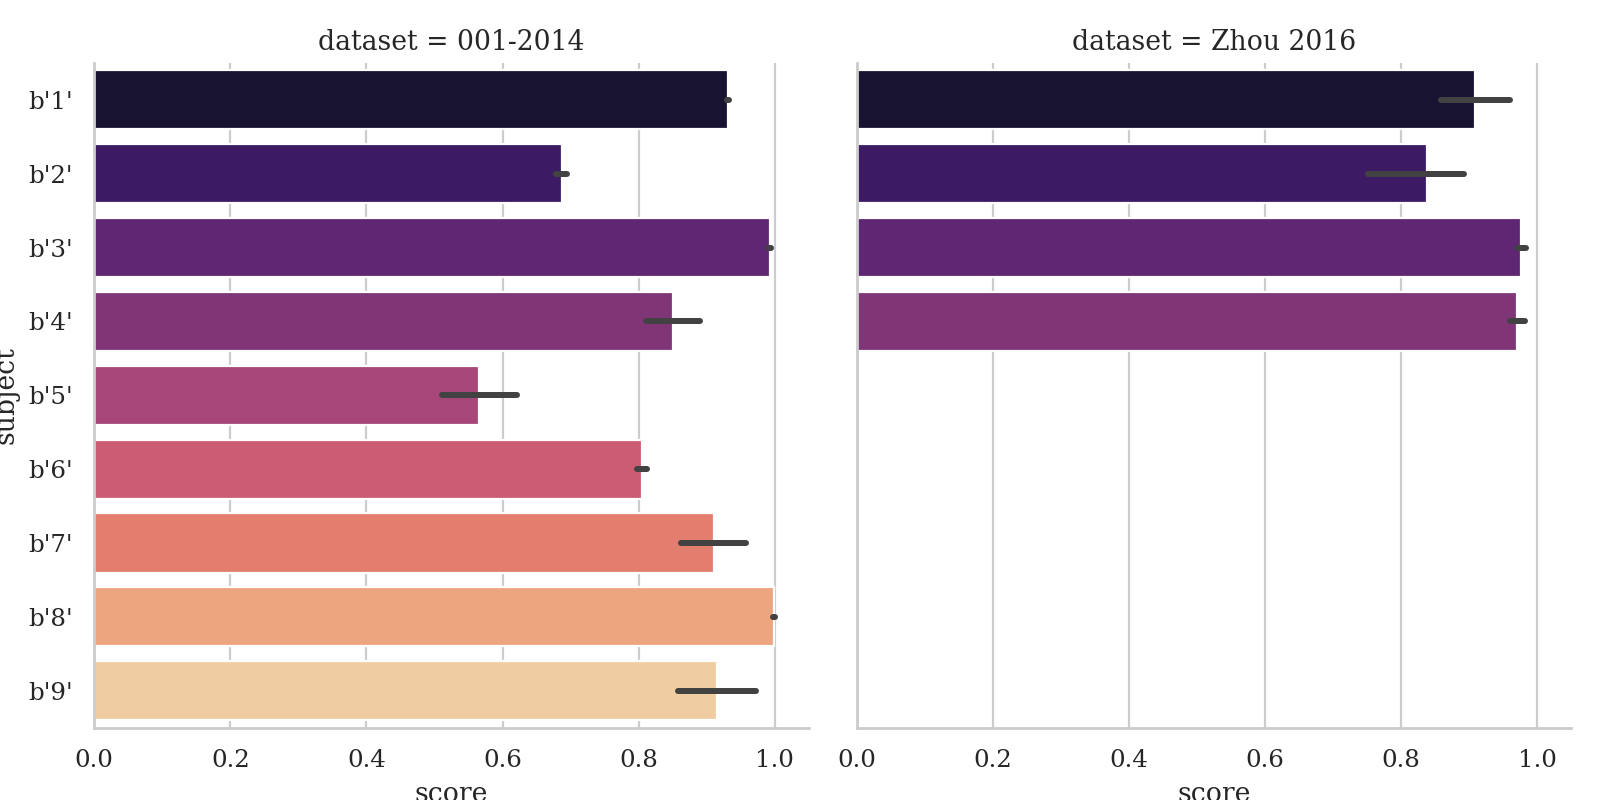

In [11]:
plot_results(results_datasets)


### Compare pipelines

In [12]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from sklearn.svm import SVC


pipelines['tgsp+svm'] = make_pipeline(Covariances('oas'), TangentSpace(metric='riemann'), SVC(kernel='linear'))
pipelines['MDM'] = make_pipeline(Covariances('oas'), MDM(metric='riemann'))

In [13]:
%%time
datasets = [Zhou2016()] # BNCI2014001(), 
evaluation = WithinSessionEvaluation(paradigm=paradigm, datasets=datasets, overwrite=True)
results_pipelines = evaluation.process(pipelines) 


Reading 0 ... 305029  =      0.000 ...  1220.116 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 430479  =      0.000 ...  1721.916 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 252599  =      0.000 ...  1010.396 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 296649  =      0.000 ...  1186.596 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/mne/io/cnt/cnt.py:241: RuntimeWarning: overflow encountered in int_scalars
  data_size // (n_samples * n_channels) not in [2, 4]):
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 233249  =      0.000 ...   932.996 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 226219  =      0.000 ...   904.876 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 14 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 14 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 14 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 14 dim * 3.5e+15  max singular value)
    Estimated rank (

    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 14 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Reading 0 ... 227539  =      0.000 ...   910.156 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/mne/io/cnt/cnt.py:241: RuntimeWarning: overflow encountered in int_scalars
  data_size // (n_samples * n_channels) not in [2, 4]):
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 216079  =      0.000 ...   864.316 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 213939  =      0.000 ...   855.756 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 175269  =      0.000 ...   701.076 secs...
Reading 0 ... 213209  =      0.000 ...   852.836 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_r

Reading 0 ... 217659  =      0.000 ...   870.636 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Computing rank from data with rank=None
    Using tolerance 6.7 (2.2e-16 eps * 14 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 14 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6 (2.2e-16 eps * 14 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 14 dim * 3.3e+15  max singular value)
    Estimated rank

    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.8 (2.2e-16 eps * 14 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Reading 0 ... 219849  =      0.000 ...   879.396 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 216709  =      0.000 ...   866.836 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 226609  =      0.000 ...   906.436 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 266929  =      0.000 ...  1067.716 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 227989  =      0.000 ...   911.956 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 222459  =      0.000 ...   889.836 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/mne/io/cnt/cnt.py:241: RuntimeWarning: overflow encountered in int_scalars
  data_size // (n_samples * n_channels) not in [2, 4]):
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 14 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 14 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 14 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 14 dim * 3.5e+15  max singular value)
    Estimated rank (

    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 14 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Reading 0 ... 181339  =      0.000 ...   725.356 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 217139  =      0.000 ...   868.556 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 215399  =      0.000 ...   861.596 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 212209  =      0.000 ...   848.836 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 209799  =      0.000 ...   839.196 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 217109  =      0.000 ...   868.436 secs...


/Users/raph/Code/timeflux/workshops/notebooks/moabb/venv/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:104: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 14 dim * 4e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 14 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 14 dim * 4e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 14 dim * 4.1e+15  max singular value)
    Estimated rank (mag)

    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 14 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
CPU times: user 1min 27s, sys: 32 s, total: 1min 59s
Wall time: 34.7 s


<IPython.core.display.Javascript object>


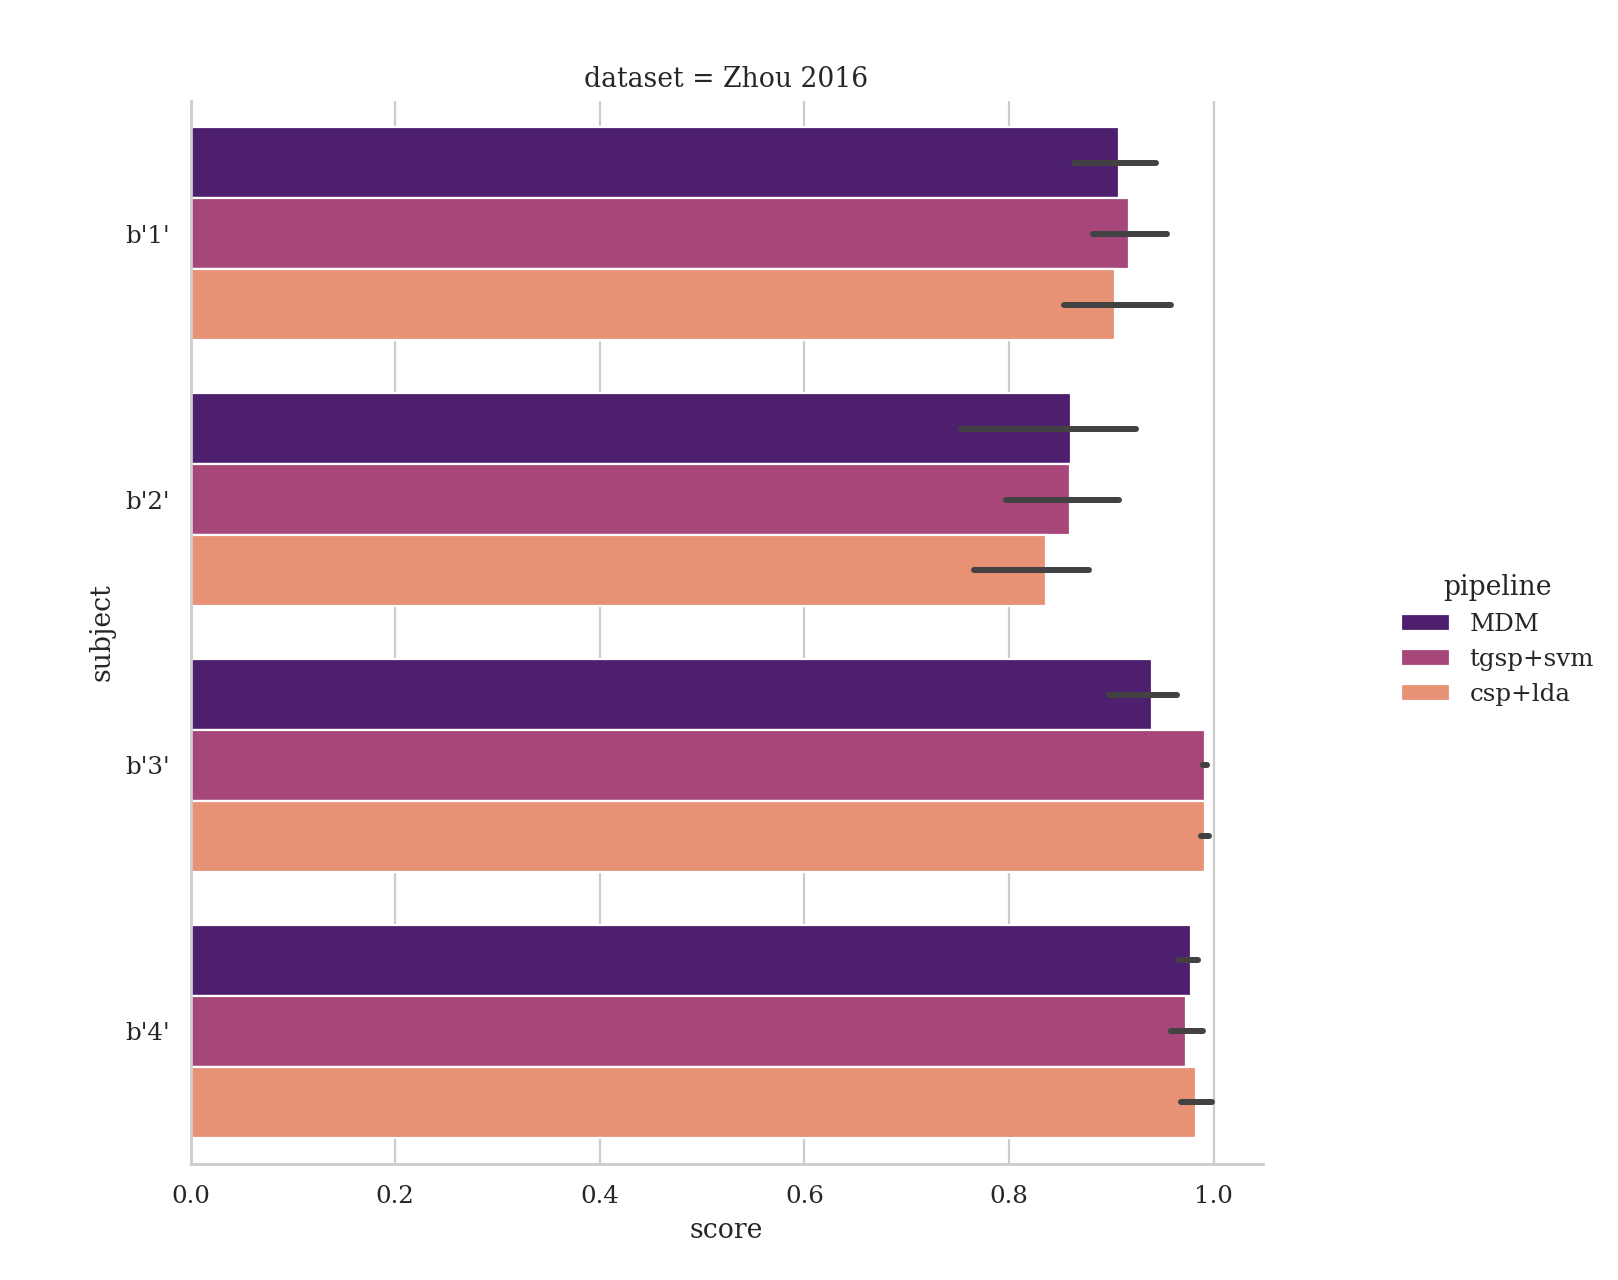

In [14]:
plot_results(results_pipelines, hue="pipeline")

## P300 

In [15]:
from moabb.paradigms import P300
from moabb.datasets import EPFLP300

paradigm = P300()
dataset = EPFLP300()

sessions = dataset._get_single_subject_data(subject=1)
raw = sessions["session_1"]["run_1"]

In [16]:
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[1])

<IPython.core.display.Javascript object>


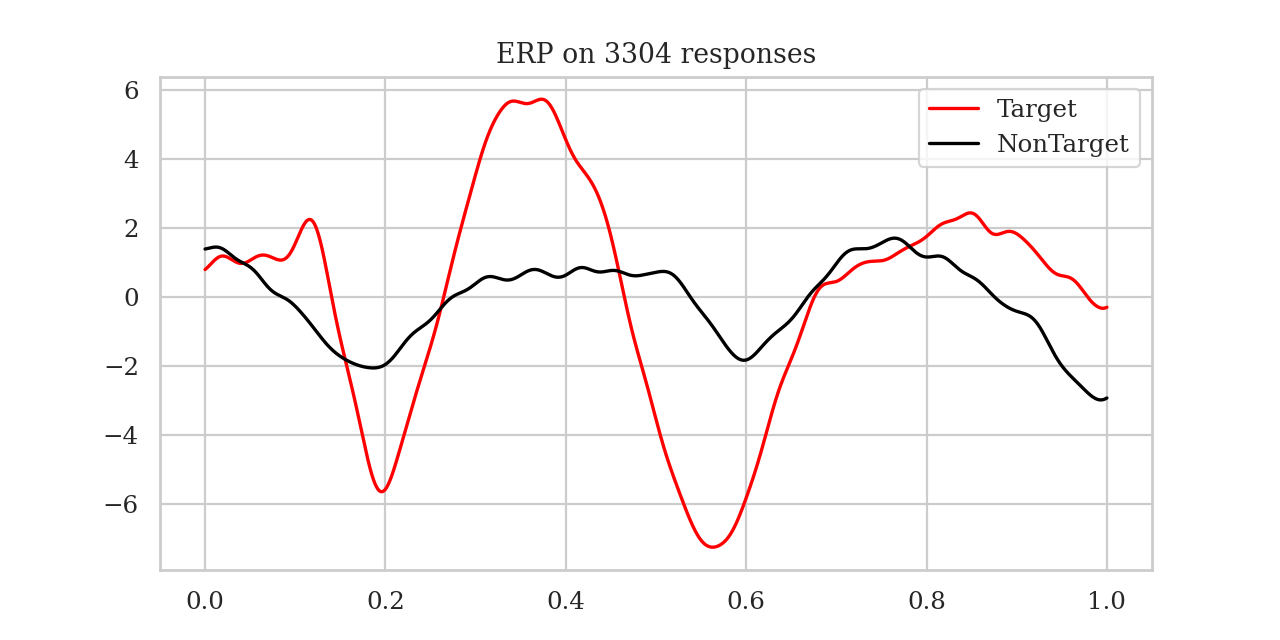

In [17]:
plt.figure(figsize=(8,4))
time = np.arange(0, 1/raw.info["sfreq"]*X.shape[-1] , 1/raw.info["sfreq"])
plt.plot(time, -np.mean(X[labels=="Target", 0, :], axis=0).T, color="r"); 
plt.plot(time, -np.mean(X[labels=="NonTarget", 0, :], axis=0).T, color="k");
plt.legend(["Target", "NonTarget"])
plt.title(f"ERP on {len(labels)} responses"); 

In [18]:
from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import LogisticRegression
from sklearn.svm import SVC

# build your pipeline
covest = ERPCovariances(estimator="oas")
ts = TangentSpace()
logreg = LogisticRegression(solver='lbfgs')

pipeline = make_pipeline(covest,ts,logreg)
pipelines = {"erp-cov + ts + logreg": pipeline}

In [19]:
train_runs = ["run_1"]
test_runs = ["run_2"]

X_train = X[meta.run.isin(train_runs), :, :]
y_train = labels[meta.run.isin(train_runs)]
X_test = X[meta.run.isin(test_runs), :, :]
y_test = labels[meta.run.isin(test_runs)]


In [20]:
%%time
y_predicted = pipeline.fit(X_train, y_train).predict(X_test)

CPU times: user 1min 25s, sys: 34.5 s, total: 1min 59s
Wall time: 19.7 s


<IPython.core.display.Javascript object>


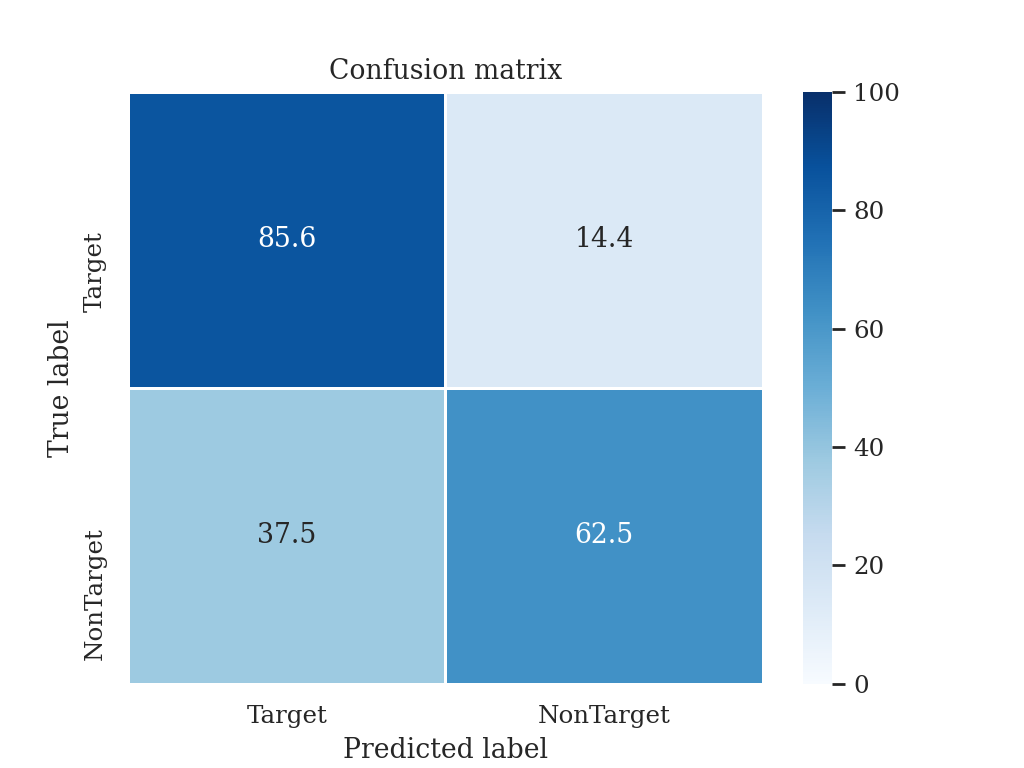

In [21]:
from pyriemann.utils.viz import plot_confusion_matrix
names = ['Target', "NonTarget"]
plt.figure()
plot_confusion_matrix(y_predicted, y_test, names); 